# STEP 0

## 0.1. Imports


In [4]:
import optuna
import numpy                    as np
import pandas                   as pd
import seaborn                  as sns
import matplotlib.pyplot        as plt
from sklearn.model_selection    import train_test_split
from sklearn.ensemble           import RandomForestRegressor
from catboost                   import CatBoostRegressor, Pool
from sklearn.linear_model       import LinearRegression, Lasso
from sklearn.preprocessing      import MinMaxScaler, RobustScaler
from sklearn.preprocessing      import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection    import StratifiedKFold, cross_validate, cross_val_score
from sklearn.metrics            import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.feature_selection  import SelectKBest, chi2, f_regression


## 0.2. Funções de apoio

In [5]:
# ===================================================================
# Configura o notebook
def jupyter_settings():
    import warnings
    warnings.filterwarnings('ignore')
    %matplotlib inline

    # Tamanho e estilo dos gráficos
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [22, 9]
    plt.rcParams['font.size'] = 21

    # Configuração de exibição das linhas e colunas do pandas
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)

    # configuração do pandas para quantidade de casas decimais
    pd.set_option('display.float_format', lambda x: '%.3f' % x)

    sns.set()

jupyter_settings()

# Imprime n gráficos do tipo boxplot lado a lado
def exibe_boxplot(data, col):
    indice = 1
    for coluna in data.columns:
        plt.subplot(1, col, indice)
        sns.boxplot(data[coluna]).set(title=coluna)
        indice += 1


def plota_ausentes(data, title, x_title):
    """
    Plota uma tabela com a contagem de valores ausentes por coluna e um gráfico de
    barras com o percentual de ausentes por colunas caso existam dados ausentes,
    caso não, imprime o resultado de isna().sum()
    Params
    data: dataframe com os dados a serem plotados
    title: título do gráfico
    title: título do eixo x
    """

    # Pega as colunas com dados ausentes
    colunas_com_nan = [col for col in data.columns if data[col].isna().sum() > 0]

    # Plot do gráfico de barras com o percentual
    if len(colunas_com_nan) > 0:    # Se tiver colunas com dados faltantes
        ax = (  # Grafico                              
            data[colunas_com_nan]   # Dataframe a ser plotado no gráfico
            .isna() # Pegar valores faltantes
            .mean() # Pegar a média dos valores faltantes
            .sort_values(ascending=True)    # Ordenar os dados 
            .mul(100)   # multiplicar a média por 100 (percentual)
            .round(1)   # Arredondar as casas decimais para 1
            .plot(kind="barh")  # Tipo do gráfico (barras horizontais)
        )
        _ = ax.set_xlabel(x_title)  # Título do eixo x
        _ = ax.set_title(title) # Título do gráfico
        _ = ax.bar_label(ax.containers[0])  # Mostrar valores sobre as barras

        # Tabela da contagems dos dados faltantes
        print("Contagem de faltantes")
        print(data[colunas_com_nan].isna().sum().sort_values(ascending=True))
    else:   # Caso não exista dados faltantes imprime uma lista das colunas
        print('Contagem de faltantes')
        print(data.isna().sum())


def plota_metricas(nome_modelo, y_real, y_predito):
    # Avaliando o modelo
    mae = mean_absolute_error(y_real, y_predito)
    mape = mean_absolute_percentage_error(y_real, y_predito)
    rmse = np.sqrt(mean_squared_error(y_real, y_predito))
    r2 = r2_score(y_real, y_predito)

    # =======================================
    # Criando a tabela de métricas
    # =======================================
    linhas = [[nome_modelo, r2, mae, mape, rmse]]
    colunas = ["Modelo", "R2", "MAE", "MAPE", "RMSE"]

    metricas =  pd.DataFrame(linhas, columns=colunas)

    return metricas


def transforma_dados(data):
    '''
    Função para transformaar os dados de treino e validação
    '''
    # Instancia o transformador para features sem variância
    tr_constant = DropConstantFeatures(tol=0.7, missing_values='ignore', confirm_variables=False)

    # # Treina o transformador
    tr_constant.fit(data)

    # Imprime as features a serem excluídas
    features_constantes = tr_constant.features_to_drop_

    # Dropa as colunas sem variância
    data.drop(columns=features_constantes, inplace=True)

    display(features_constantes)


    # Instancia o transformador para features correlacionadas
    tr_correlated = DropCorrelatedFeatures(method='pearson', threshold=0.8, missing_values='ignore')

    # Treina o transformador
    tr_correlated.fit(data)

    # Features correlacionadas
    pares_correlacionadas = tr_correlated.correlated_feature_sets_

    # Variáveis à serem excluídas
    features_correlacionadas = tr_correlated.features_to_drop_

    print('Pares de variáveis correlacionadas:')
    display(pares_correlacionadas)

    print('Variáveis à serem excluídas:')
    display(features_correlacionadas)

## 0.3. Carregando os dados

In [6]:
# Leitura dos dados principais
df_raw = pd.read_csv('../data/df_case_1_-_500_linhas.csv')

# 1 - Entendimento dos dados


In [7]:
df = df_raw.copy()
df.head(5)

,CATEGORIA,PRODUTO,FORNECEDOR,COMPRADOR,CENTROS DE DISTRIBUICAO,DESCRICAO,QTD DE CAIXAS,MAR22,ABR22,MAI22,JUN22,JUL22,AGO22,SET22,OUT22,NOV22,DEZ22,JAN23,FEV23,MAR23,ABR23,MAI23,JUN23,JUL23,AGO23,SET23,OUT23,NOV23,DEZ23,JAN24,FEV24,MAR24
0,A,A,A,A,A,A,109,356,374,408,453,413,323,276,296,512,554,658,352,484,513,369,404,350,466,290,476,524,273,199,313,197
1,A,A,A,A,B,B,70,994,723,1310,1214,1105,1530,1445,1721,1284,1607,1483,1497,2006,1285,1529,1897,1840,2427,1655,1669,1970,1700,1895,1385,2243
2,B,B,B,B,C,C,123,74,65,71,63,59,132,148,163,80,171,5,1,80,167,120,144,57,69,165,129,153,149,145,125,132
3,B,C,C,C,D,D,196,520,466,603,320,700,700,554,475,516,529,508,417,455,327,362,496,568,443,304,408,372,315,447,610,776
4,A,D,A,A,E,E,99,37,1,78,74,9,75,7,64,35,28,80,64,37,85,3,75,60,85,13,45,24,8,64,79,96


In [8]:
df.columns

Index(['CATEGORIA', 'PRODUTO', 'FORNECEDOR', 'COMPRADOR',
       'CENTROS DE DISTRIBUICAO', 'DESCRICAO', 'QTD DE CAIXAS', 'MAR22',
       'ABR22', 'MAI22', 'JUN22', 'JUL22', 'AGO22', 'SET22', 'OUT22', 'NOV22',
       'DEZ22', 'JAN23', 'FEV23', 'MAR23', 'ABR23', 'MAI23', 'JUN23', 'JUL23',
       'AGO23', 'SET23', 'OUT23', 'NOV23', 'DEZ23', 'JAN24', 'FEV24', 'MAR24'],
      dtype='object')

## 1.1. Renomear as colunas

## 1.2. Volumetria dos dados

In [9]:
# Conferindo a volumetria
print(f"Quantidade de colunas:  {df.shape[1]}")
print(f"Quantidade de linhas:   {df.shape[0]}")
# print(f"IDs únicos:             {df.id.nunique()}")

Quantidade de colunas:  32
Quantidade de linhas:   500


## 1.3. Tipos dos dados

In [10]:
df.dtypes

CATEGORIA                  object
PRODUTO                    object
FORNECEDOR                 object
COMPRADOR                  object
CENTROS DE DISTRIBUICAO    object
DESCRICAO                  object
QTD DE CAIXAS               int64
MAR22                       int64
ABR22                       int64
MAI22                       int64
JUN22                       int64
JUL22                       int64
AGO22                       int64
SET22                       int64
OUT22                       int64
NOV22                       int64
DEZ22                       int64
JAN23                       int64
FEV23                       int64
MAR23                       int64
ABR23                       int64
MAI23                       int64
JUN23                       int64
JUL23                       int64
AGO23                       int64
SET23                       int64
OUT23                       int64
NOV23                       int64
DEZ23                       int64
JAN24         

## 1.4. alterando o tipo dos dados

In [183]:
# Reduzindo tamanho em memória das features para melhor performance

## 1.5. Verificando dados faltantes


In [11]:
plota_ausentes(df, '% de faltantes', 'Percentual')

Contagem de faltantes
CATEGORIA                  0
PRODUTO                    0
FORNECEDOR                 0
COMPRADOR                  0
CENTROS DE DISTRIBUICAO    0
DESCRICAO                  0
QTD DE CAIXAS              0
MAR22                      0
ABR22                      0
MAI22                      0
JUN22                      0
JUL22                      0
AGO22                      0
SET22                      0
OUT22                      0
NOV22                      0
DEZ22                      0
JAN23                      0
FEV23                      0
MAR23                      0
ABR23                      0
MAI23                      0
JUN23                      0
JUL23                      0
AGO23                      0
SET23                      0
OUT23                      0
NOV23                      0
DEZ23                      0
JAN24                      0
FEV24                      0
MAR24                      0
dtype: int64


## 1.7. Estatística Descritiva


In [12]:
# Separando os atributos entre numéricos e categóricos
numericos = df.select_dtypes(include=['float', 'int'])

categoricos = df.select_dtypes(exclude=['float', 'int',])

### 1.7.1 Atributos Numéricos

In [13]:
numericos.describe().T

,count,mean,std,min,25%,50%,75%,max
QTD DE CAIXAS,500.000,104.142,80.827,7.000,62.000,92.000,125.250,1059.000
MAR22,500.000,346.214,1088.250,1.000,46.000,83.000,174.500,12032.000
ABR22,500.000,256.946,690.142,1.000,48.000,85.000,154.250,7421.000
MAI22,500.000,370.864,1309.882,1.000,49.000,86.500,207.250,16940.000
JUN22,500.000,377.400,1208.011,1.000,47.000,85.000,204.000,16075.000
JUL22,500.000,369.646,1291.152,-10.000,47.000,87.000,206.000,18188.000
AGO22,500.000,349.626,1113.840,1.000,47.750,82.500,199.500,13183.000
SET22,500.000,309.992,1111.135,1.000,49.750,84.000,183.750,19875.000
OUT22,500.000,271.764,765.725,1.000,47.000,85.500,173.750,10000.000
NOV22,500.000,340.622,940.957,1.000,51.750,91.000,198.250,10626.000


### 1.7.2 Atributos Categóricos

In [14]:
categoricos.apply(lambda x: x.unique().shape[0])
for col in categoricos.columns:
    display(df[col].value_counts())

CATEGORIA
B    271
A    150
C     53
D     15
E      8
F      2
G      1
Name: count, dtype: int64

PRODUTO
R    42
S    41
G    39
B    39
K    34
P    29
A    27
F    26
D    26
J    24
I    19
T    17
H    16
M    15
V    14
C    14
E    13
X    12
W    11
Q    10
Y     7
O     7
L     7
N     5
Z     5
U     1
Name: count, dtype: int64

FORNECEDOR
A    85
G    60
B    48
H    44
M    42
K    40
E    37
F    31
C    28
L    28
I    12
R     8
O     6
Q     5
N     5
S     4
J     3
V     3
D     2
U     2
W     2
P     1
T     1
X     1
Y     1
Z     1
Name: count, dtype: int64

COMPRADOR
C    227
A    116
B     95
D     62
Name: count, dtype: int64

CENTROS DE DISTRIBUICAO
D    40
G    37
H    32
A    31
C    31
B    30
F    29
E    28
K    19
J    18
M    18
S    17
V    16
N    16
U    14
I    14
W    14
Y    14
R    12
T    12
Z    12
P    11
Q    11
L    11
O     9
X     4
Name: count, dtype: int64

DESCRICAO
N    23
J    22
P    22
K    22
F    22
T    21
Z    21
D    21
A    20
R    20
U    20
E    19
B    19
O    19
X    19
V    18
G    18
L    18
M    18
Y    18
W    18
H    17
S    17
Q    17
I    16
C    15
Name: count, dtype: int64

### 1.8 Variável Target

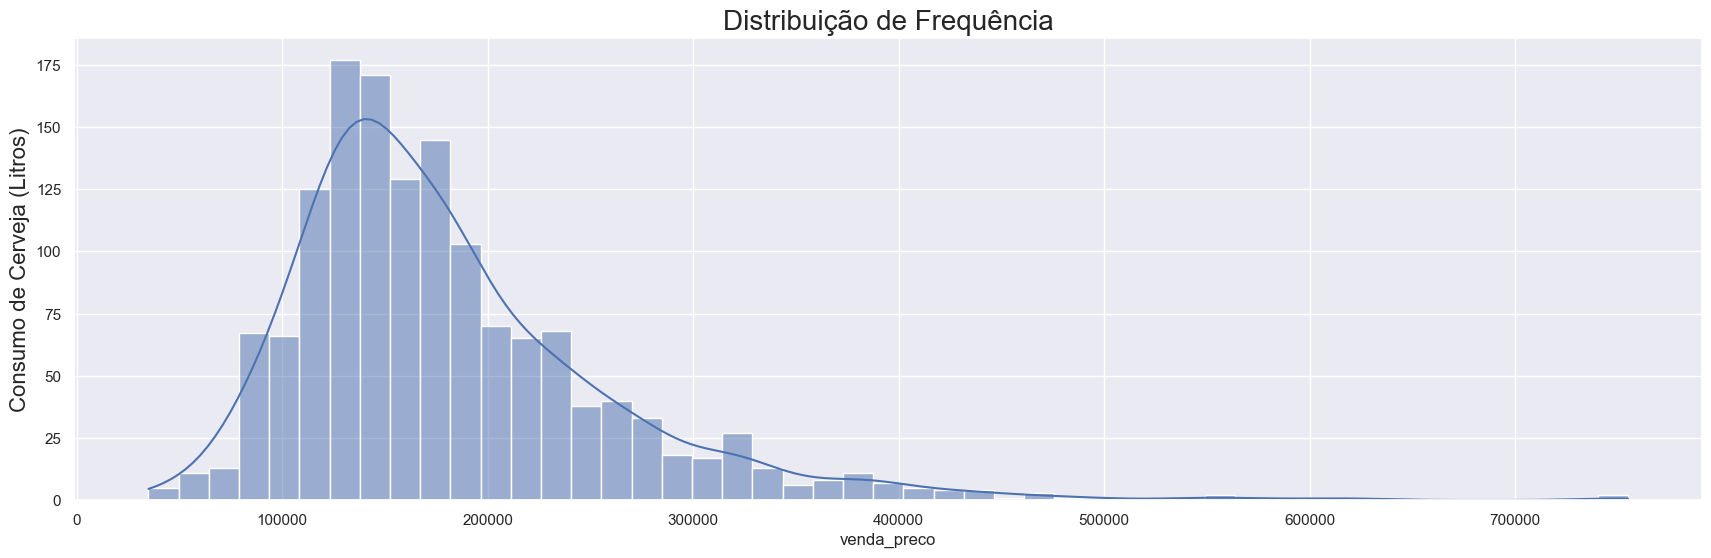

In [188]:
ax = sns.histplot(df['venda_preco'], kde=True)
ax.figure.set_size_inches(21, 6)
ax.set_title('Distribuição de Frequência', fontsize = 20)
ax.set_ylabel('Consumo de Cerveja (Litros)', fontsize = 16);

# 2 - Análise exploratória dos dados

## 2.1. Análise Univariada

### Verificando a distribuição das variáveis numéricas

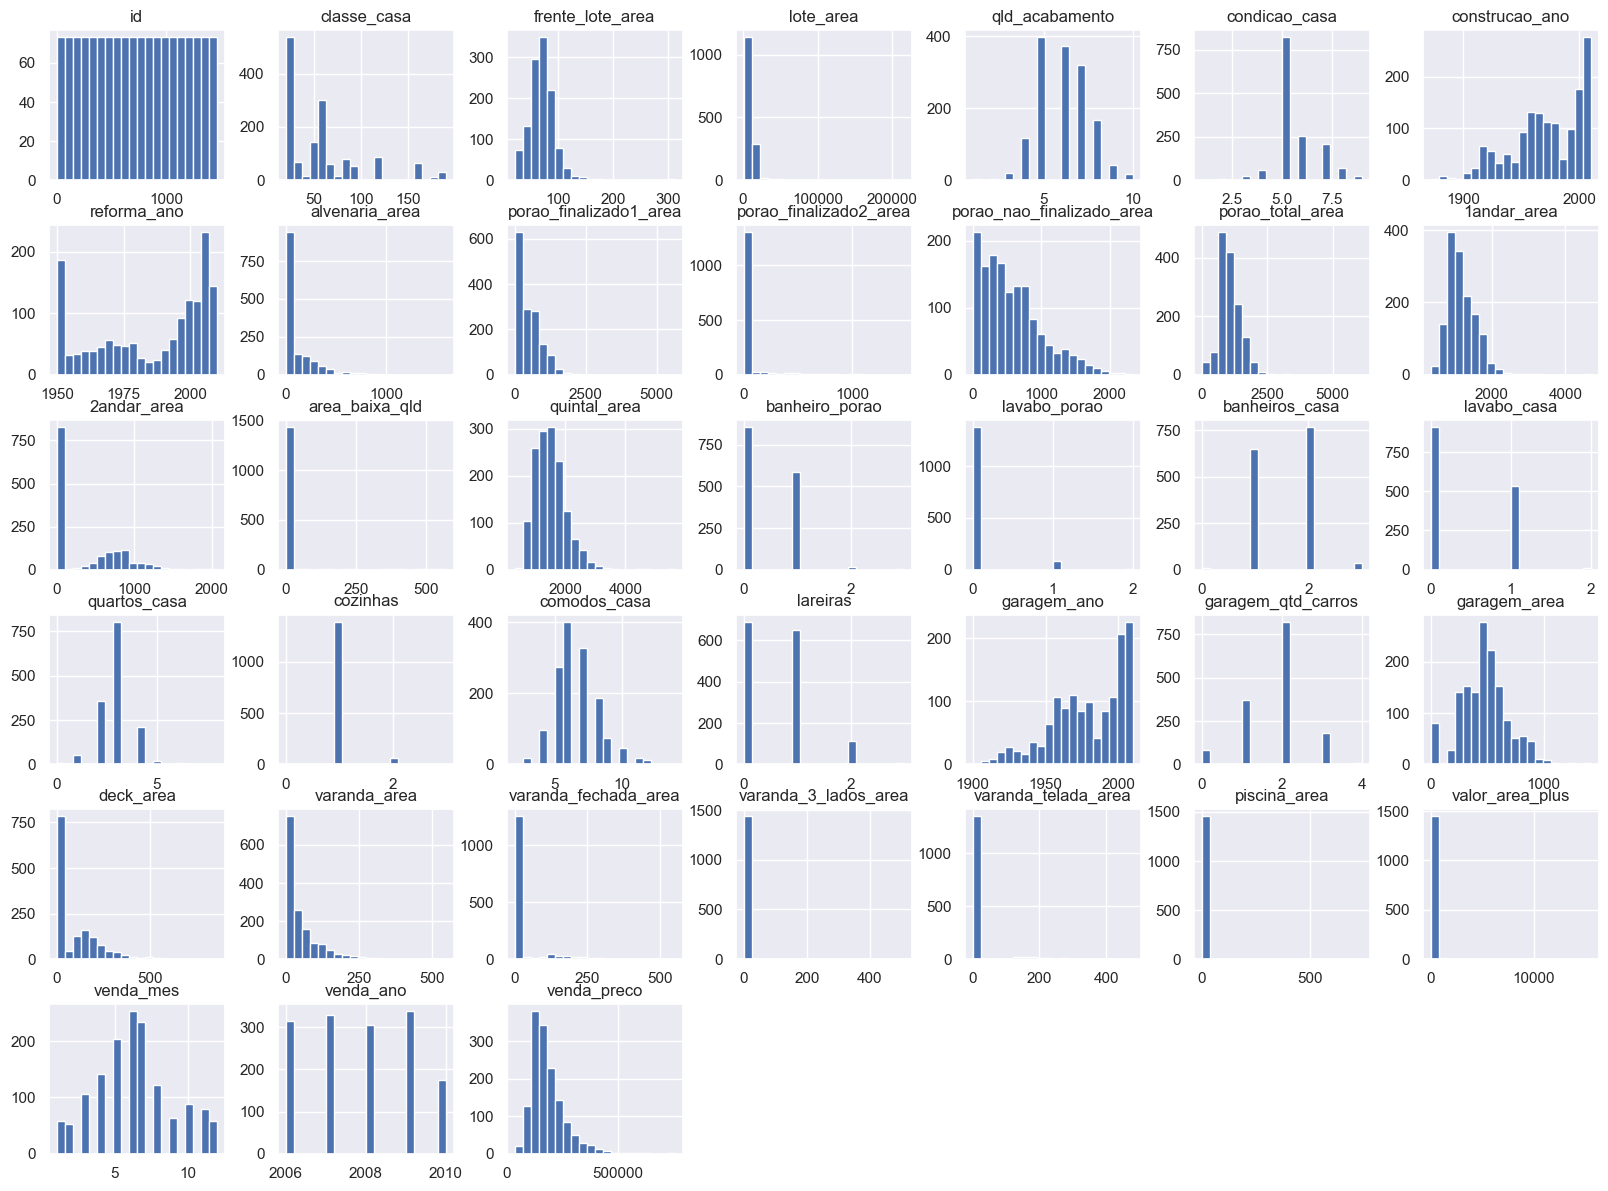

In [189]:
# Plotagem do histograma das variáveis numéricas
# numericos.hist(bins=20);
numericos.hist(bins=20, layout=(20, 7), figsize=(20, 50));

### Verificando os outliers das variáveis numéricas

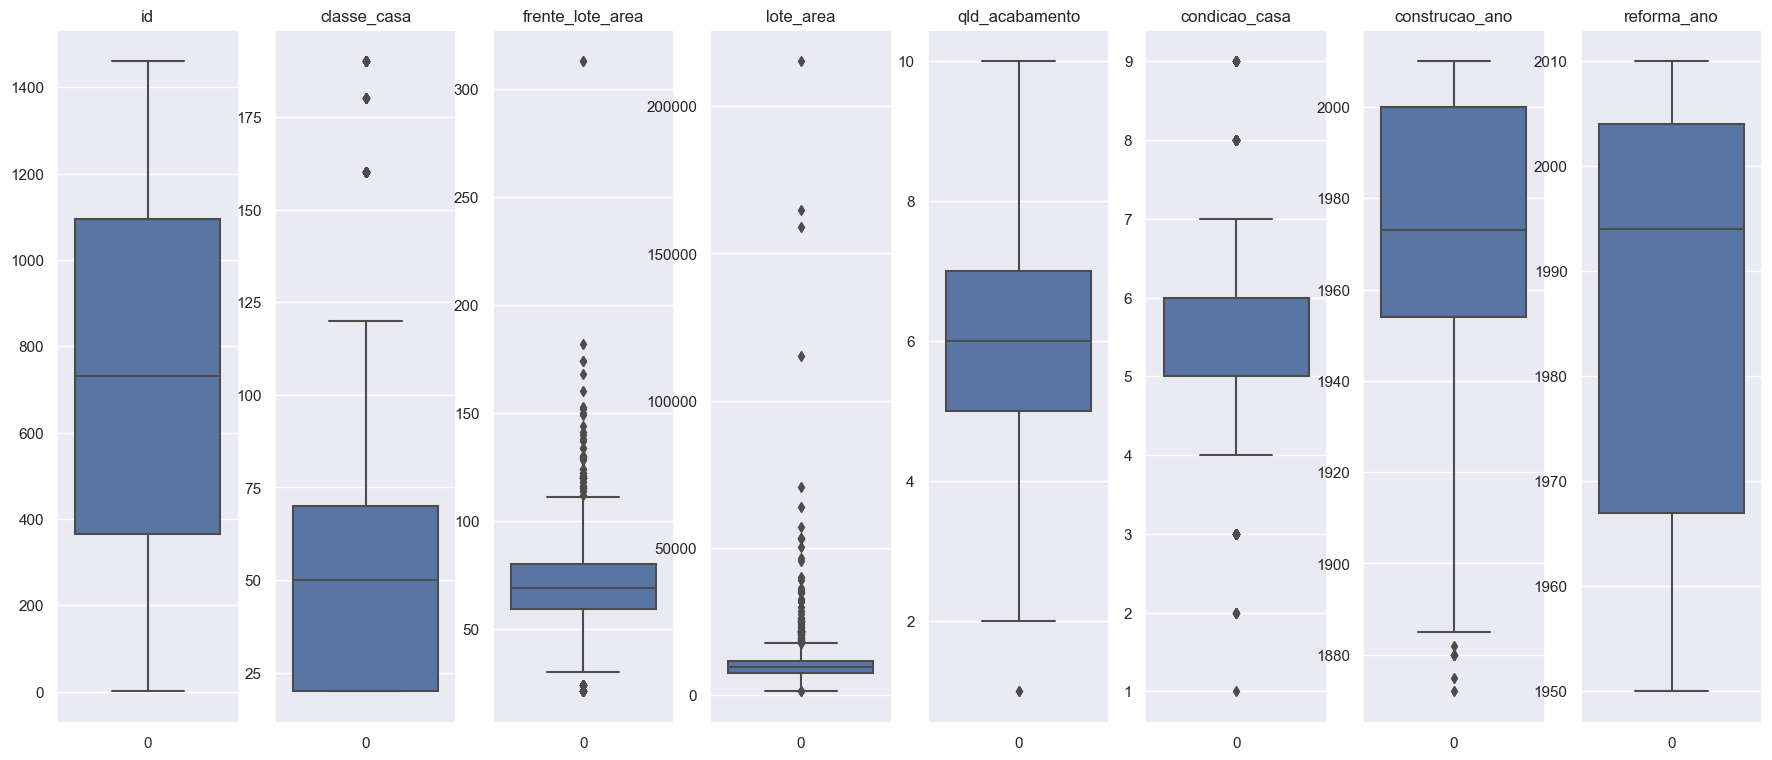

In [190]:
exibe_boxplot(numericos.iloc[:, :8], 8)

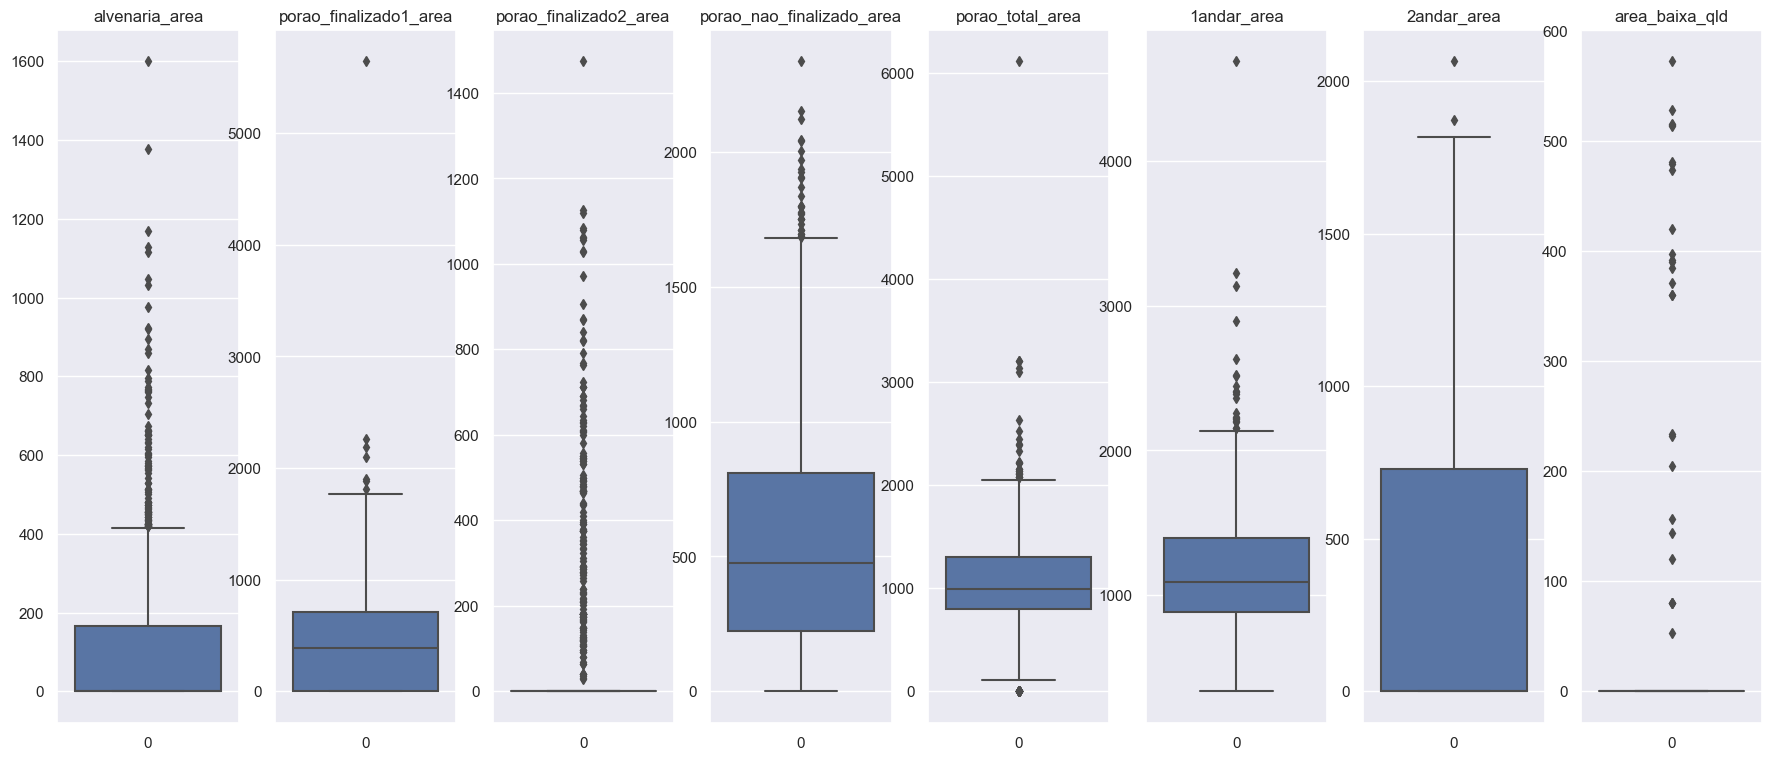

In [191]:
exibe_boxplot(numericos.iloc[:, 8:16], 8)

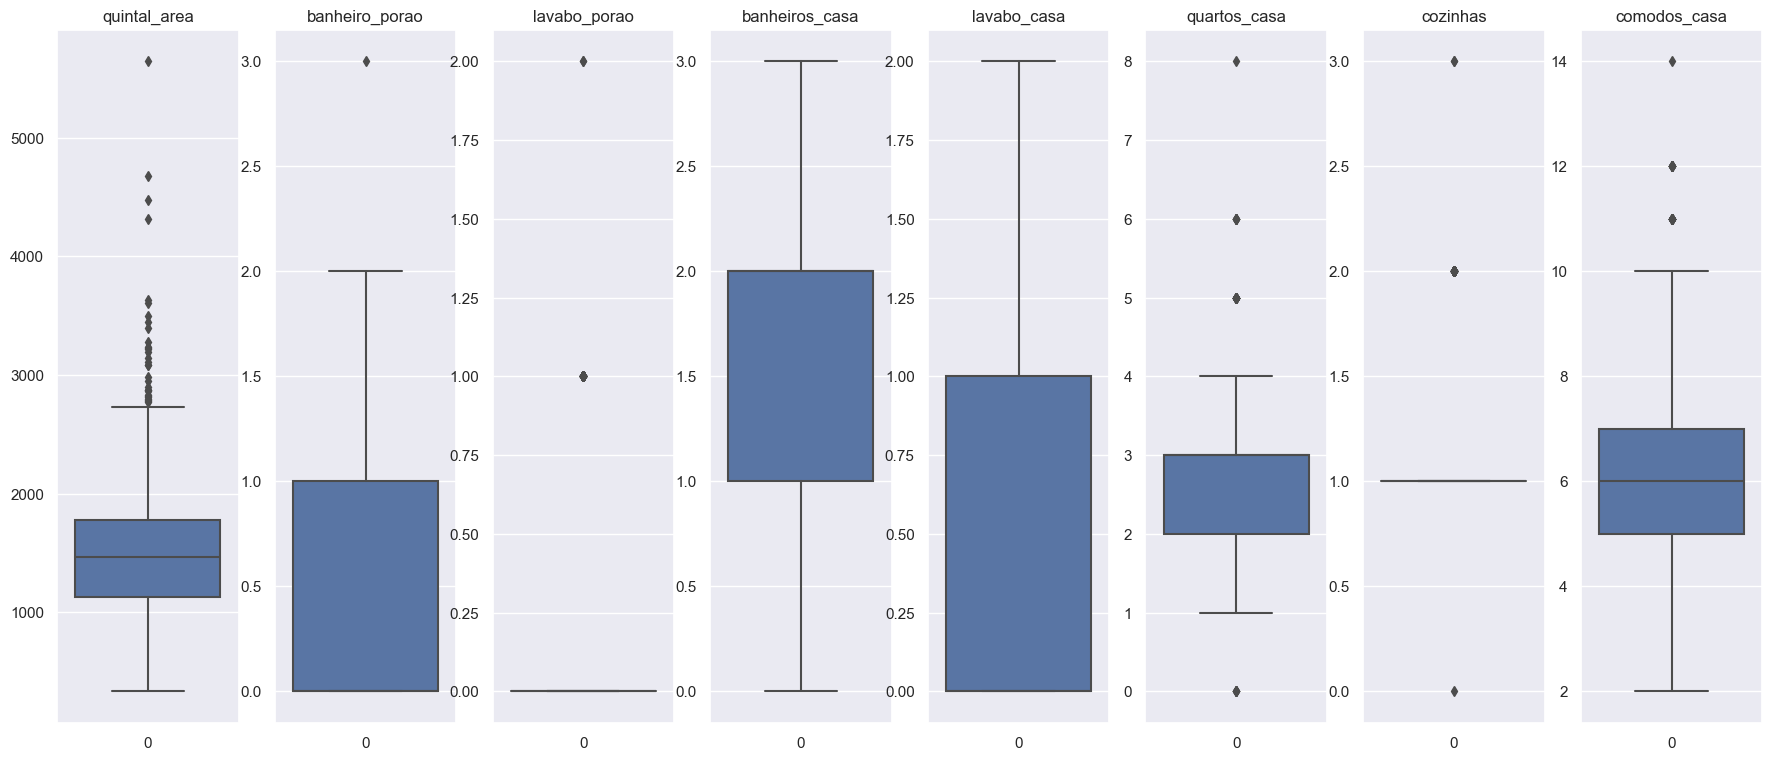

In [192]:
exibe_boxplot(numericos.iloc[:, 16:24], 8)

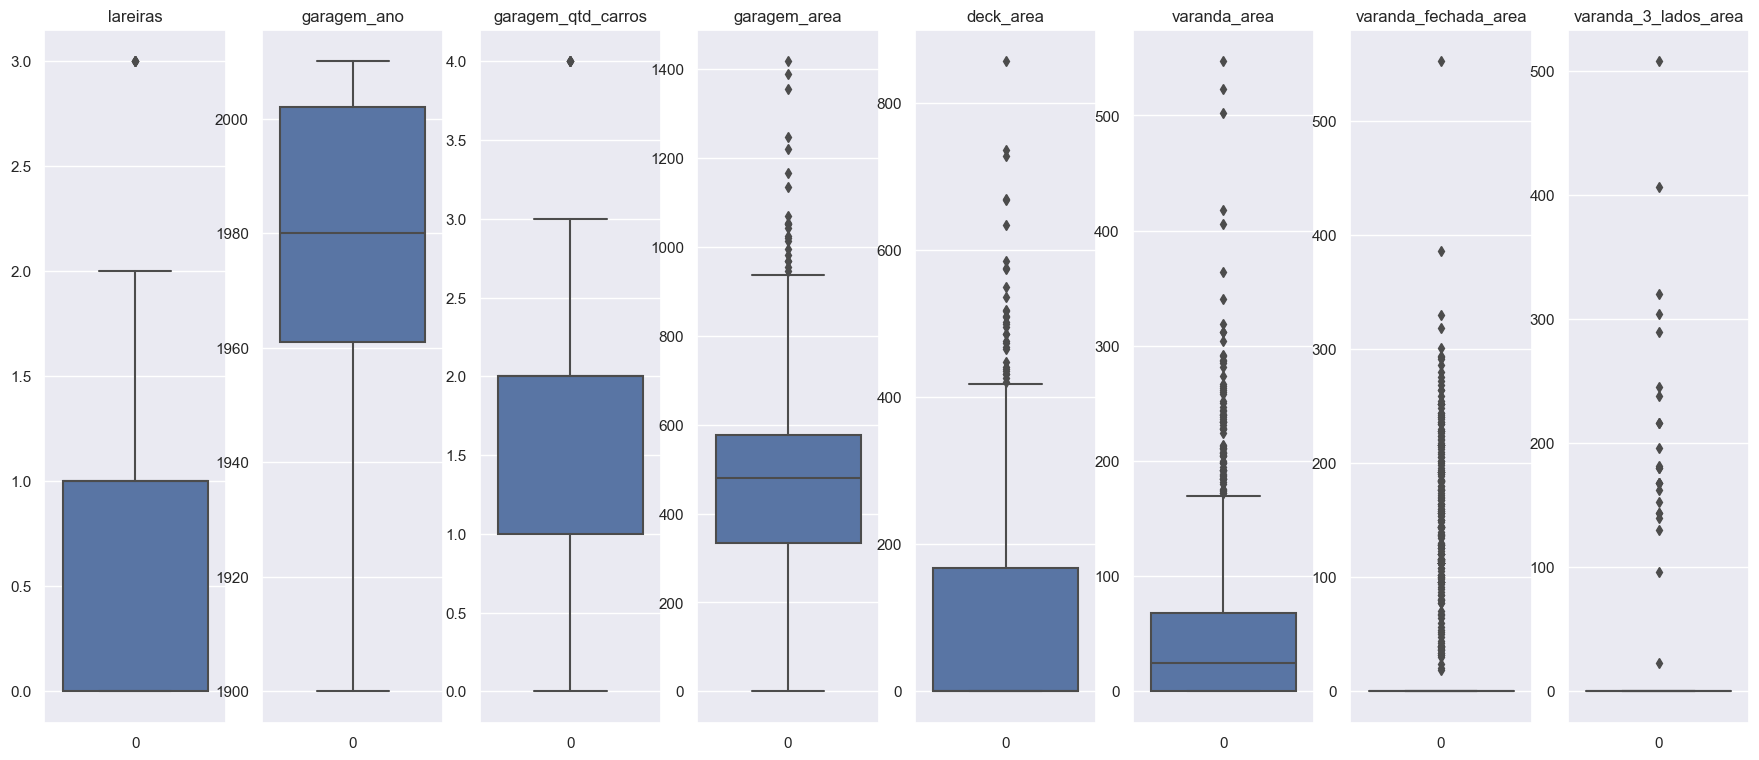

In [193]:
exibe_boxplot(numericos.iloc[:, 24:32], 8)

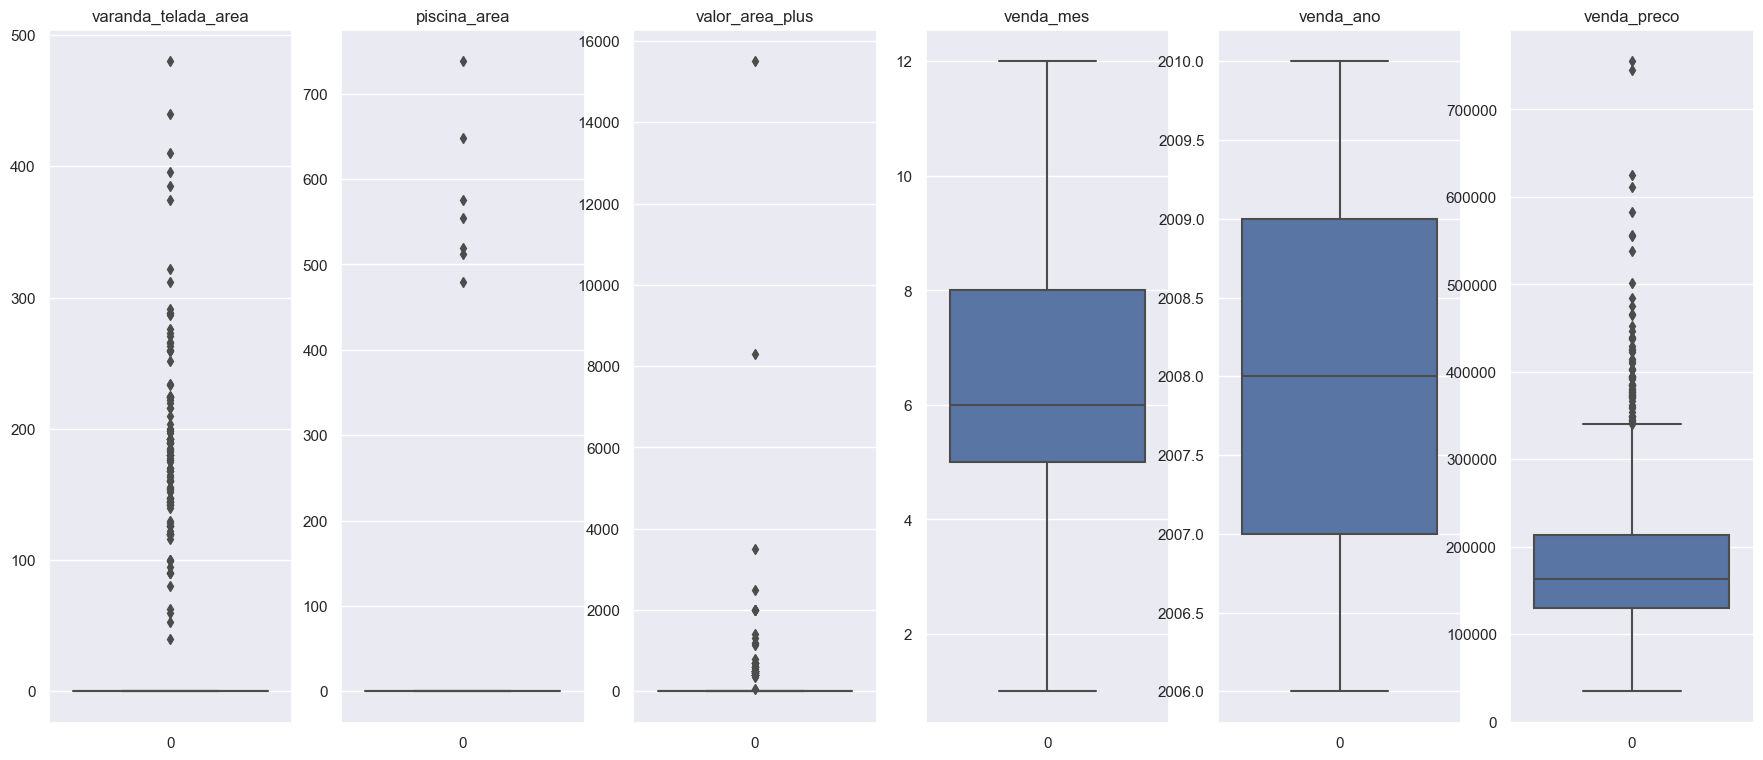

In [194]:
exibe_boxplot(numericos.iloc[:, 32:], 6)

## 2.2. Análise Bivariada

Text(0.5, 0, 'Zoneamento')

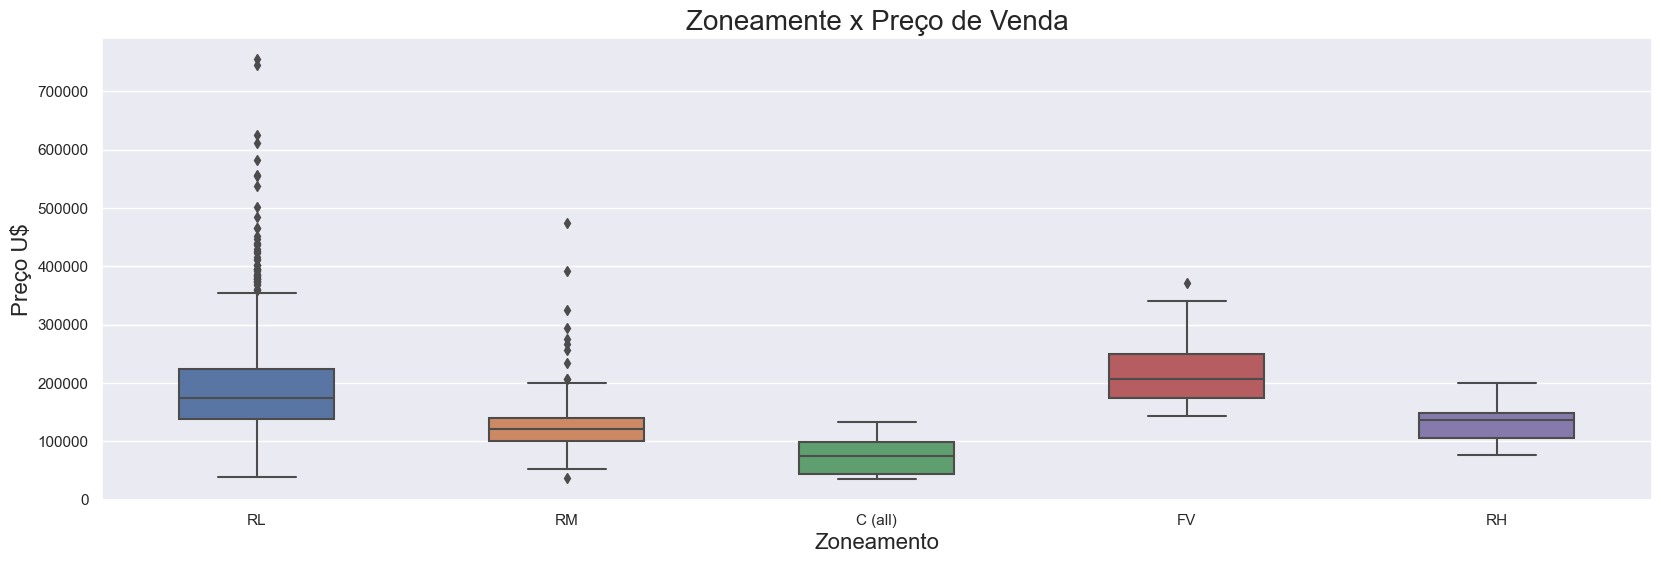

In [195]:
ax = sns.boxplot(y="venda_preco", x="zoneamento", data=df, orient="v", width=0.5)
ax.figure.set_size_inches(20, 6)
ax.set_title("Zoneamente x Preço de Venda", fontsize=20)
ax.set_ylabel("Preço U$", fontsize=16)
ax.set_xlabel("Zoneamento", fontsize=16)

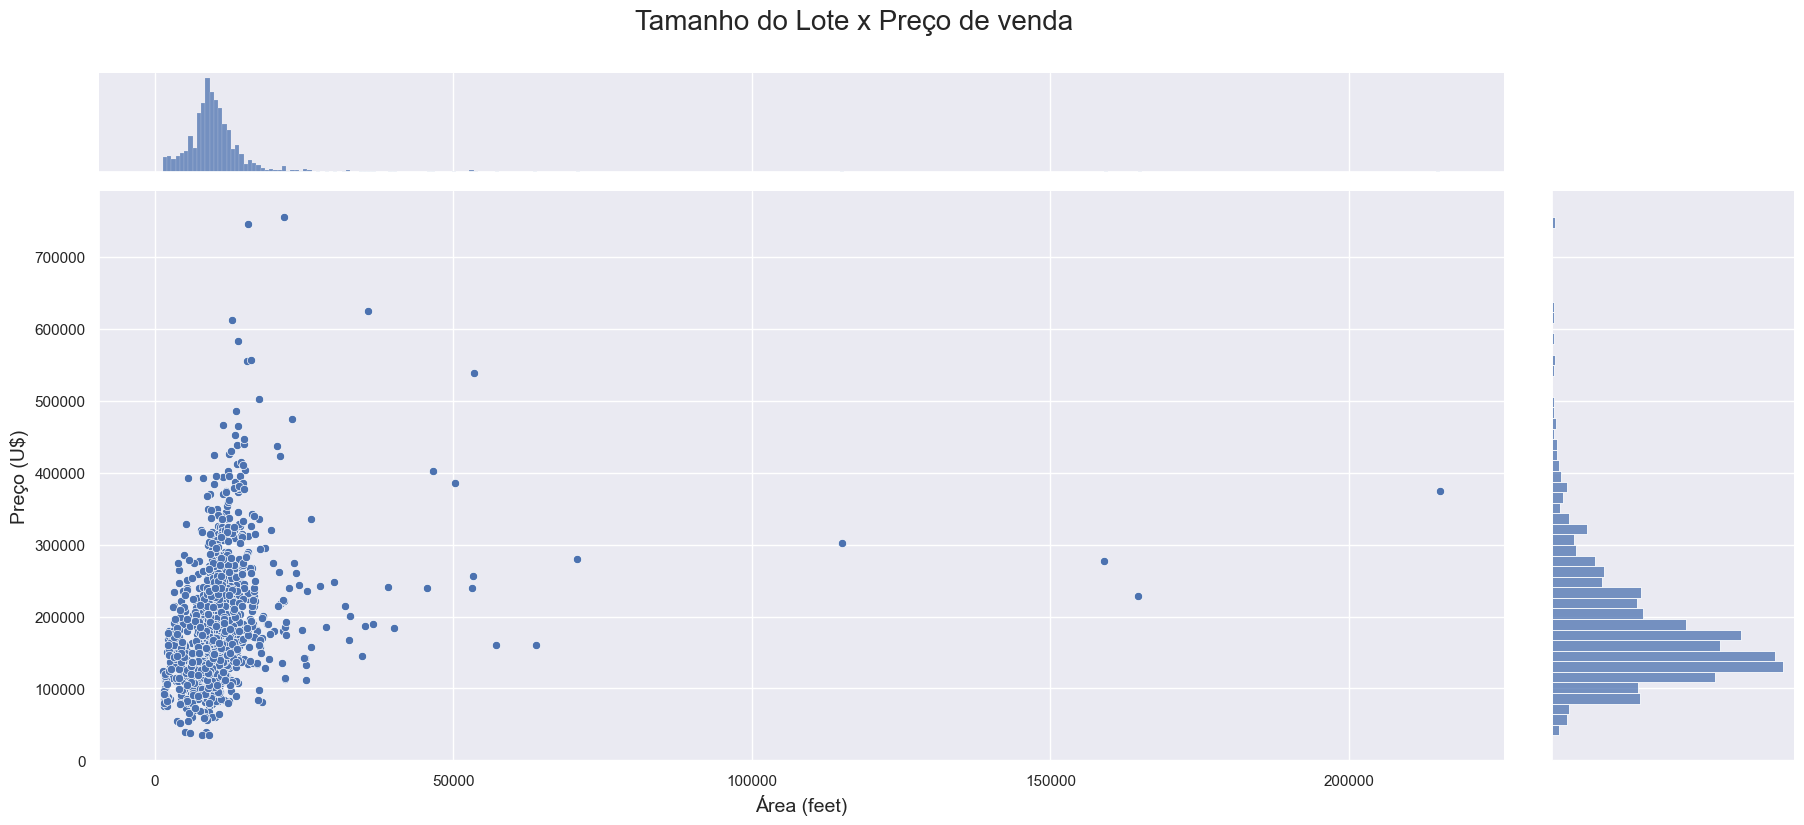

In [196]:
ax = sns.jointplot(x="lote_area", y="venda_preco", data=df)
ax.figure.set_size_inches(20, 8)
ax.fig.suptitle("Tamanho do Lote x Preço de venda", fontsize=20, y=1.05)
ax.set_axis_labels("Área (feet)", "Preço (U$)", fontsize=14)
ax;

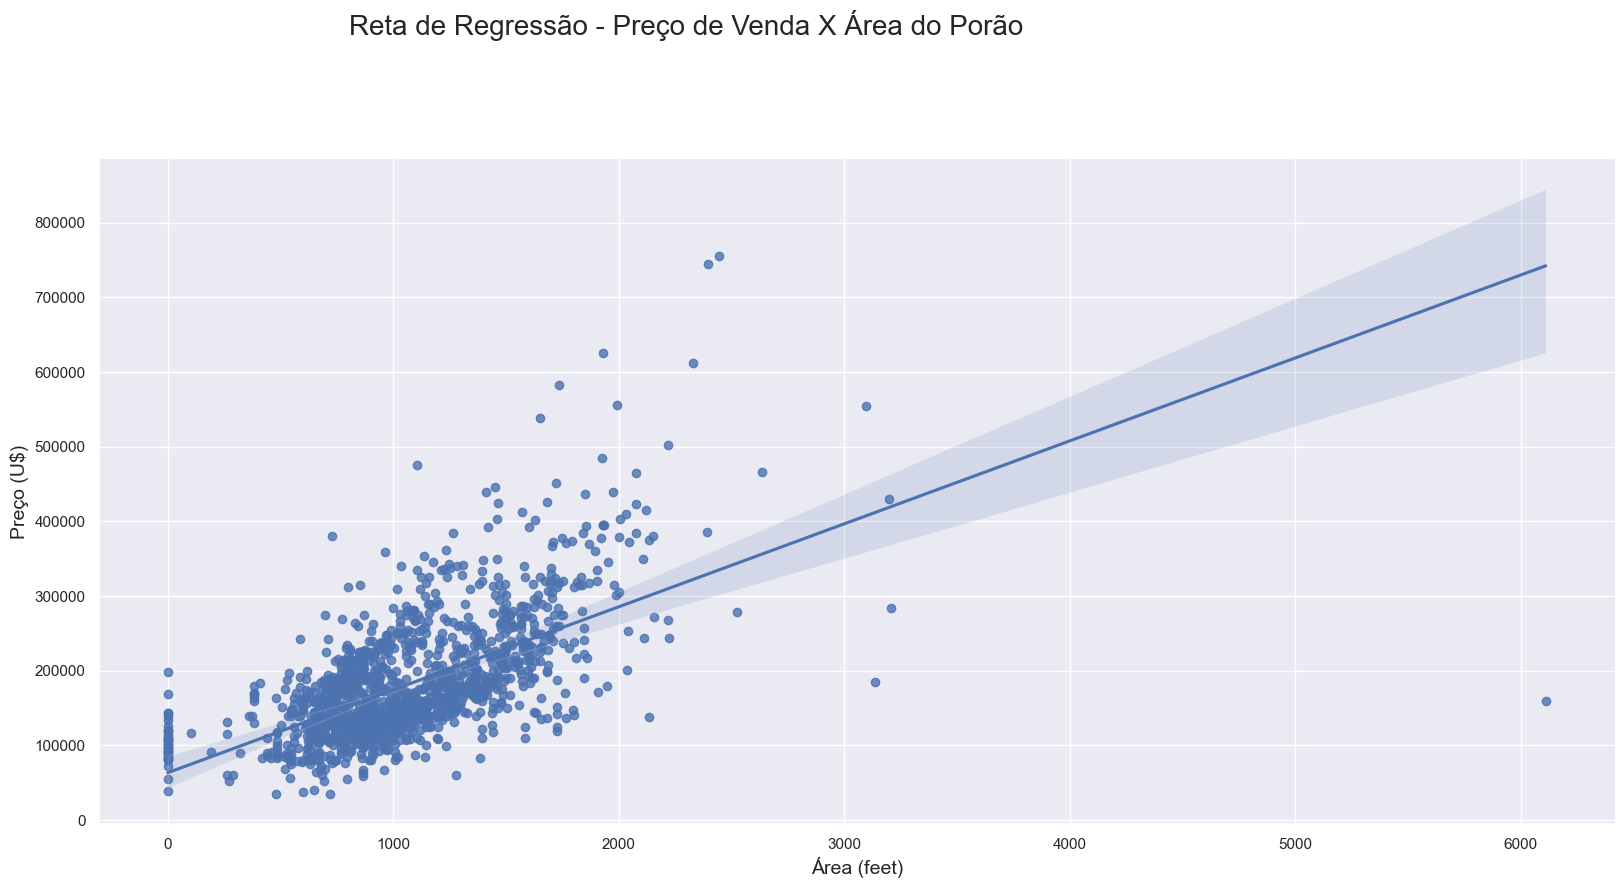

In [197]:
ax = sns.lmplot(x="porao_total_area", y="venda_preco", data=df)
ax.figure.set_size_inches(20, 8)
ax.fig.suptitle("Reta de Regressão - Preço de Venda X Área do Porão", fontsize=20, y=1.15)
ax.set_xlabels("Área (feet)", fontsize=14)
ax.set_ylabels("Preço (U$)", fontsize=14)
ax;

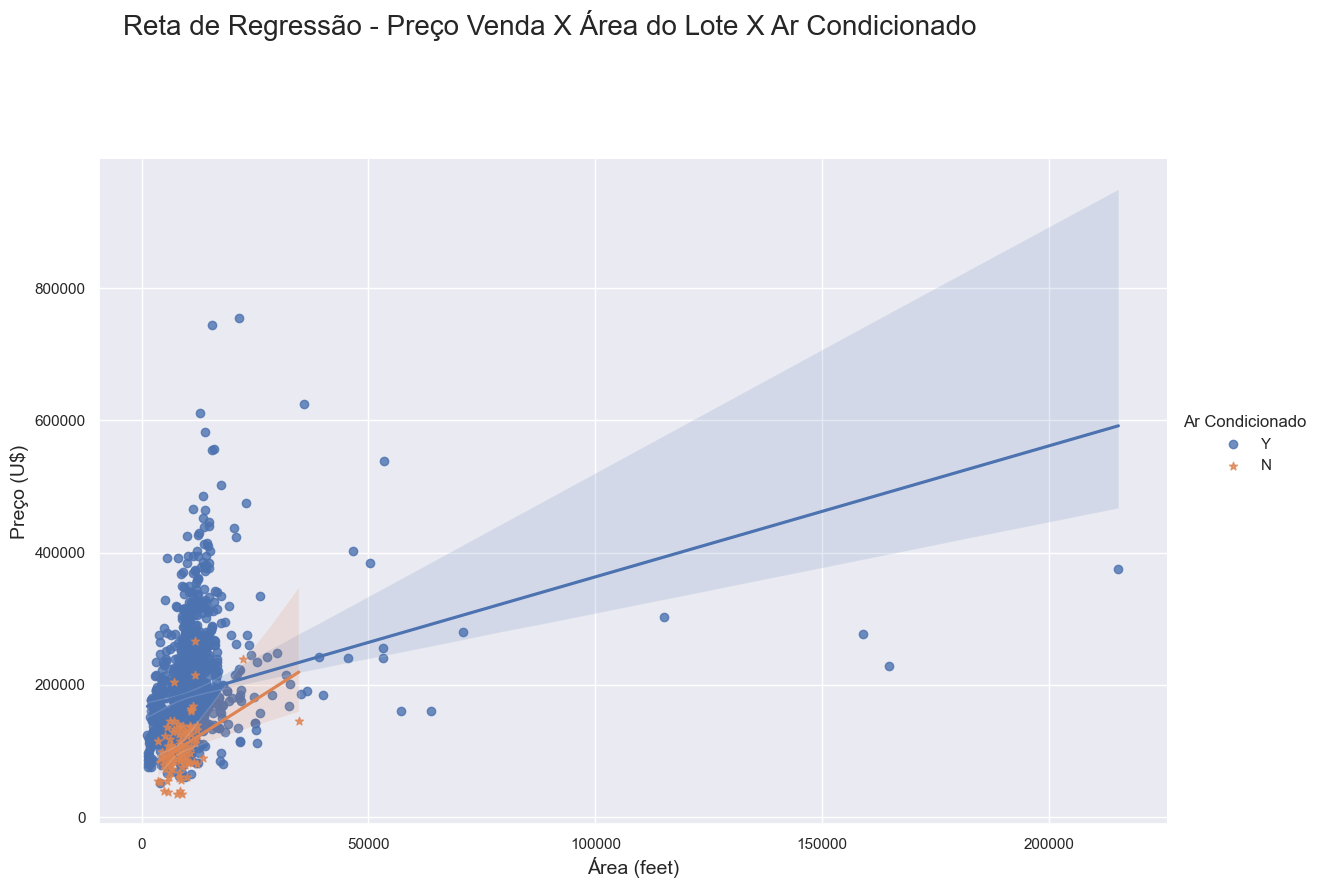

In [198]:
ax = sns.lmplot(x="lote_area", y="venda_preco", data=df, hue="ar_condic", markers=["o", "*"], legend=False)
ax.figure.set_size_inches(14, 8)
ax.fig.suptitle("Reta de Regressão - Preço Venda X Área do Lote X Ar Condicionado", fontsize=20, y=1.15)
ax.set_xlabels("Área (feet)", fontsize=14)
ax.set_ylabels("Preço (U$)", fontsize=14)
ax.add_legend(title="Ar Condicionado")
ax;

## 2.3. Análise Multivariada

### Verificando a correlação entre as variáveis

In [199]:
corr = numericos.corr().round(1)
corr

,id,classe_casa,frente_lote_area,lote_area,qld_acabamento,condicao_casa,construcao_ano,reforma_ano,alvenaria_area,porao_finalizado1_area,porao_finalizado2_area,porao_nao_finalizado_area,porao_total_area,1andar_area,2andar_area,area_baixa_qld,quintal_area,banheiro_porao,lavabo_porao,banheiros_casa,lavabo_casa,quartos_casa,cozinhas,comodos_casa,lareiras,garagem_ano,garagem_qtd_carros,garagem_area,deck_area,varanda_area,varanda_fechada_area,varanda_3_lados_area,varanda_telada_area,piscina_area,valor_area_plus,venda_mes,venda_ano,venda_preco
id,1.000,0.000,-0.000,-0.000,-0.000,0.000,-0.000,-0.000,-0.100,-0.000,-0.000,-0.000,-0.000,0.000,0.000,-0.000,0.000,0.000,-0.000,0.000,0.000,0.000,0.000,0.000,-0.000,0.000,0.000,0.000,-0.000,-0.000,0.000,-0.000,0.000,0.100,-0.000,0.000,0.000,-0.000
classe_casa,0.000,1.000,-0.400,-0.100,0.000,-0.100,0.000,0.000,0.000,-0.100,-0.100,-0.100,-0.200,-0.300,0.300,0.000,0.100,0.000,-0.000,0.100,0.200,-0.000,0.300,0.000,-0.000,0.100,-0.000,-0.100,-0.000,-0.000,-0.000,-0.000,-0.000,0.000,-0.000,-0.000,-0.000,-0.100
frente_lote_area,-0.000,-0.400,1.000,0.400,0.300,-0.100,0.100,0.100,0.200,0.200,0.000,0.100,0.400,0.500,0.100,0.000,0.400,0.100,-0.000,0.200,0.100,0.300,-0.000,0.400,0.300,0.100,0.300,0.300,0.100,0.200,0.000,0.100,0.000,0.200,0.000,0.000,0.000,0.400
lote_area,-0.000,-0.100,0.400,1.000,0.100,-0.000,0.000,0.000,0.100,0.200,0.100,-0.000,0.300,0.300,0.100,0.000,0.300,0.200,0.000,0.100,0.000,0.100,-0.000,0.200,0.300,-0.000,0.200,0.200,0.200,0.100,-0.000,0.000,0.000,0.100,0.000,0.000,-0.000,0.300
qld_acabamento,-0.000,0.000,0.300,0.100,1.000,-0.100,0.600,0.600,0.400,0.200,-0.100,0.300,0.500,0.500,0.300,-0.000,0.600,0.100,-0.000,0.600,0.300,0.100,-0.200,0.400,0.400,0.500,0.600,0.600,0.200,0.300,-0.100,0.000,0.100,0.100,-0.000,0.100,-0.000,0.800
condicao_casa,0.000,-0.100,-0.100,-0.000,-0.100,1.000,-0.400,0.100,-0.100,-0.000,0.000,-0.100,-0.200,-0.100,0.000,0.000,-0.100,-0.100,0.100,-0.200,-0.100,0.000,-0.100,-0.100,-0.000,-0.300,-0.200,-0.200,-0.000,-0.000,0.100,0.000,0.100,-0.000,0.100,-0.000,0.000,-0.100
construcao_ano,-0.000,0.000,0.100,0.000,0.600,-0.400,1.000,0.600,0.300,0.200,-0.000,0.100,0.400,0.300,0.000,-0.200,0.200,0.200,-0.000,0.500,0.200,-0.100,-0.200,0.100,0.100,0.800,0.500,0.500,0.200,0.200,-0.400,0.000,-0.100,0.000,-0.000,0.000,-0.000,0.500
reforma_ano,-0.000,0.000,0.100,0.000,0.600,0.100,0.600,1.000,0.200,0.100,-0.100,0.200,0.300,0.200,0.100,-0.100,0.300,0.100,-0.000,0.400,0.200,-0.000,-0.100,0.200,0.100,0.600,0.400,0.400,0.200,0.200,-0.200,0.000,-0.000,0.000,-0.000,0.000,0.000,0.500
alvenaria_area,-0.100,0.000,0.200,0.100,0.400,-0.100,0.300,0.200,1.000,0.300,-0.100,0.100,0.400,0.300,0.200,-0.100,0.400,0.100,0.000,0.300,0.200,0.100,-0.000,0.300,0.200,0.300,0.400,0.400,0.200,0.100,-0.100,0.000,0.100,0.000,-0.000,-0.000,-0.000,0.500
porao_finalizado1_area,-0.000,-0.100,0.200,0.200,0.200,-0.000,0.200,0.100,0.300,1.000,-0.100,-0.500,0.500,0.400,-0.100,-0.100,0.200,0.600,0.100,0.100,0.000,-0.100,-0.100,0.000,0.300,0.200,0.200,0.300,0.200,0.100,-0.100,0.000,0.100,0.100,0.000,-0.000,0.000,0.400


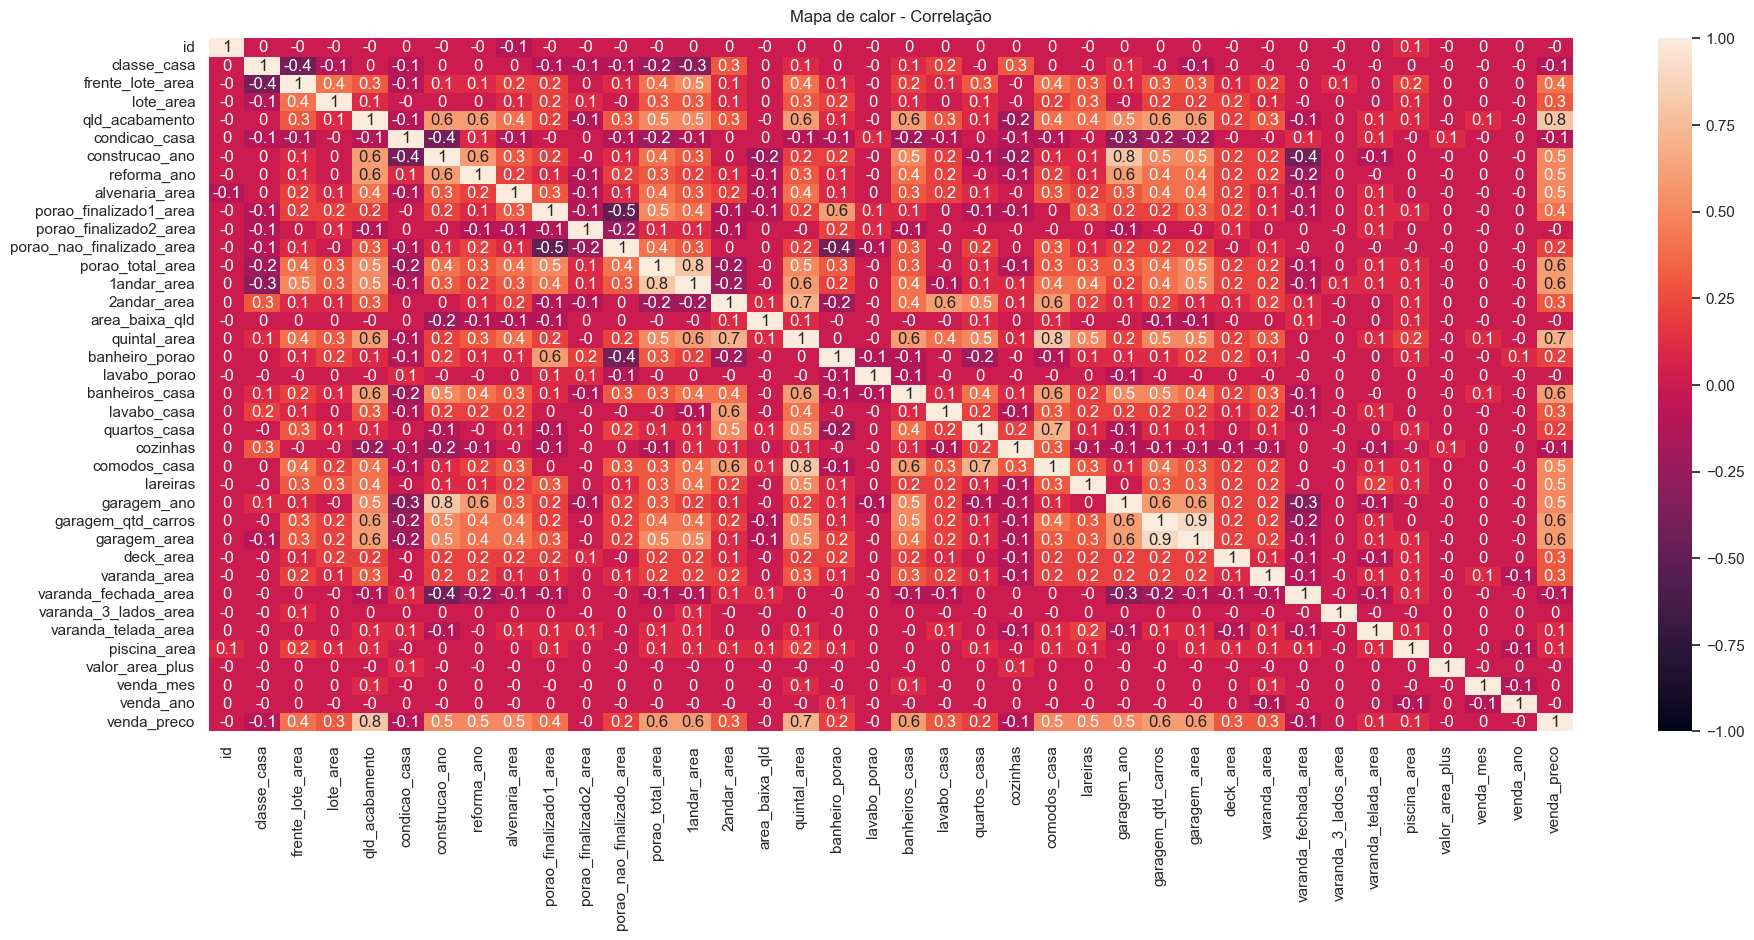

In [200]:
# Plotando mapa de calor das correlações
heatmap = sns.heatmap(corr, vmin=-1, vmax=1, annot=True)
heatmap.set_title("Mapa de calor - Correlação", fontdict={"fontsize": 12}, pad=12);

# 3 - Engenharia de Features

In [201]:
df2 = df.copy()

## 3.1. Criando features novas

## 3.2. Filtrando features com valores ausentes

In [202]:
# Dropando colunas com NaN maires que 50%
colunas_nan = [col for col in df2.columns if df[col].isna().mean() > .5]
df2.drop(columns=colunas_nan, inplace=True)

## 3.3. Filtrando features sem variância (DropConstantFeatures)

In [203]:
# Instancia o transformador com limite de 0.7
tr_constant = DropConstantFeatures(tol=0.7, missing_values='ignore', confirm_variables=False)

# # Treina o transformador
tr_constant.fit(df2)

# Imprime as features a serem excluídas
features_constantes = tr_constant.features_to_drop_

display(features_constantes)

['zoneamento',
 'pavimento_rua',
 'planicidade',
 'conveniencias_proximas',
 'tipo_lote',
 'inclinacao',
 'proximidade1',
 'proximidade2',
 'tipo_casa',
 'estilo_telhado',
 'material_telhado',
 'exterior_cond',
 'porao_cond',
 'porao_finalizado2_qld',
 'porao_finalizado2_area',
 'aquecimento_tp',
 'ar_condic',
 'painel_eletrico',
 'area_baixa_qld',
 'lavabo_porao',
 'cozinhas',
 'deducoes_qld',
 'garagem_qld',
 'garagem_cond',
 'calcada',
 'varanda_fechada_area',
 'varanda_3_lados_area',
 'varanda_telada_area',
 'piscina_area',
 'valor_area_plus',
 'venda_tipo',
 'venda_cond']

In [207]:
# Excluindo as features com baixa variância
df2.drop(columns=features_constantes, inplace=True)

## 3.4. Filtrando features correlacionadas (DropCorrelatedFeatures)

In [209]:
# Instancia o transformador
tr_correlated = DropCorrelatedFeatures(method='pearson', threshold=0.8, missing_values='ignore')

# Treina o transformador
tr_correlated.fit(df2)

# Features correlacionadas
pares_correlacionadas = tr_correlated.correlated_feature_sets_

# Variáveis à serem excluídas
features_correlacionadas = tr_correlated.features_to_drop_

print('Pares de variáveis correlacionadas:')
display(pares_correlacionadas)

print('Variáveis à serem excluídas:')
display(features_correlacionadas)

Pares de variáveis correlacionadas:


[{'construcao_ano', 'garagem_ano'},
 {'1andar_area', 'porao_total_area'},
 {'comodos_casa', 'quintal_area'},
 {'garagem_area', 'garagem_qtd_carros'}]

Variáveis à serem excluídas:


{'1andar_area', 'comodos_casa', 'garagem_ano', 'garagem_area'}

In [210]:
# Excluindo as features altamente correlacionadas
df2.drop(columns=['garagem_ano', 'garagem_qtd_carros', 'porao_total_area'], inplace=True)

# 4 - Preparação dos dados

## 4.1. Dataset split

In [146]:
df_final = df2.copy()

# Variáveis preditoras (x)
X = df_final.drop(columns=['venda_preco', 'id'])

# Variável target (y)
y = df_final['venda_preco']

# Divisão em treino e validação
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## 4.2. Tratamento de faltantes

In [147]:
# =====================================================
# Preenchendo faltantes nos dados de treino
# =====================================================
num = X_train.select_dtypes(include=np.number)
cat = X_train.select_dtypes(exclude=np.number)

# Colunas numéricas (mediana)
for col in num.columns:
    X_train[col].fillna(X_train[col].median(), inplace=True)

# Colunas categóricas (moda)
for col in cat.columns:
    X_train[col].fillna(X_train[col].value_counts().index[0], inplace=True)

# =====================================================
# Preenchendo faltantes nos dados de teste
# =====================================================
num = X_test.select_dtypes(include=np.number)
cat = X_test.select_dtypes(exclude=np.number)

# Colunas numéricas (mediana)
for col in num.columns:
    X_test[col].fillna(X_test[col].median(), inplace=True)

# Colunas categóricas (moda)
for col in cat.columns:
    X_test[col].fillna(X_test[col].value_counts().index[0], inplace=True)

## Feature importance (CatBoost)


Text(0.5, 1.0, 'Feature Importance')

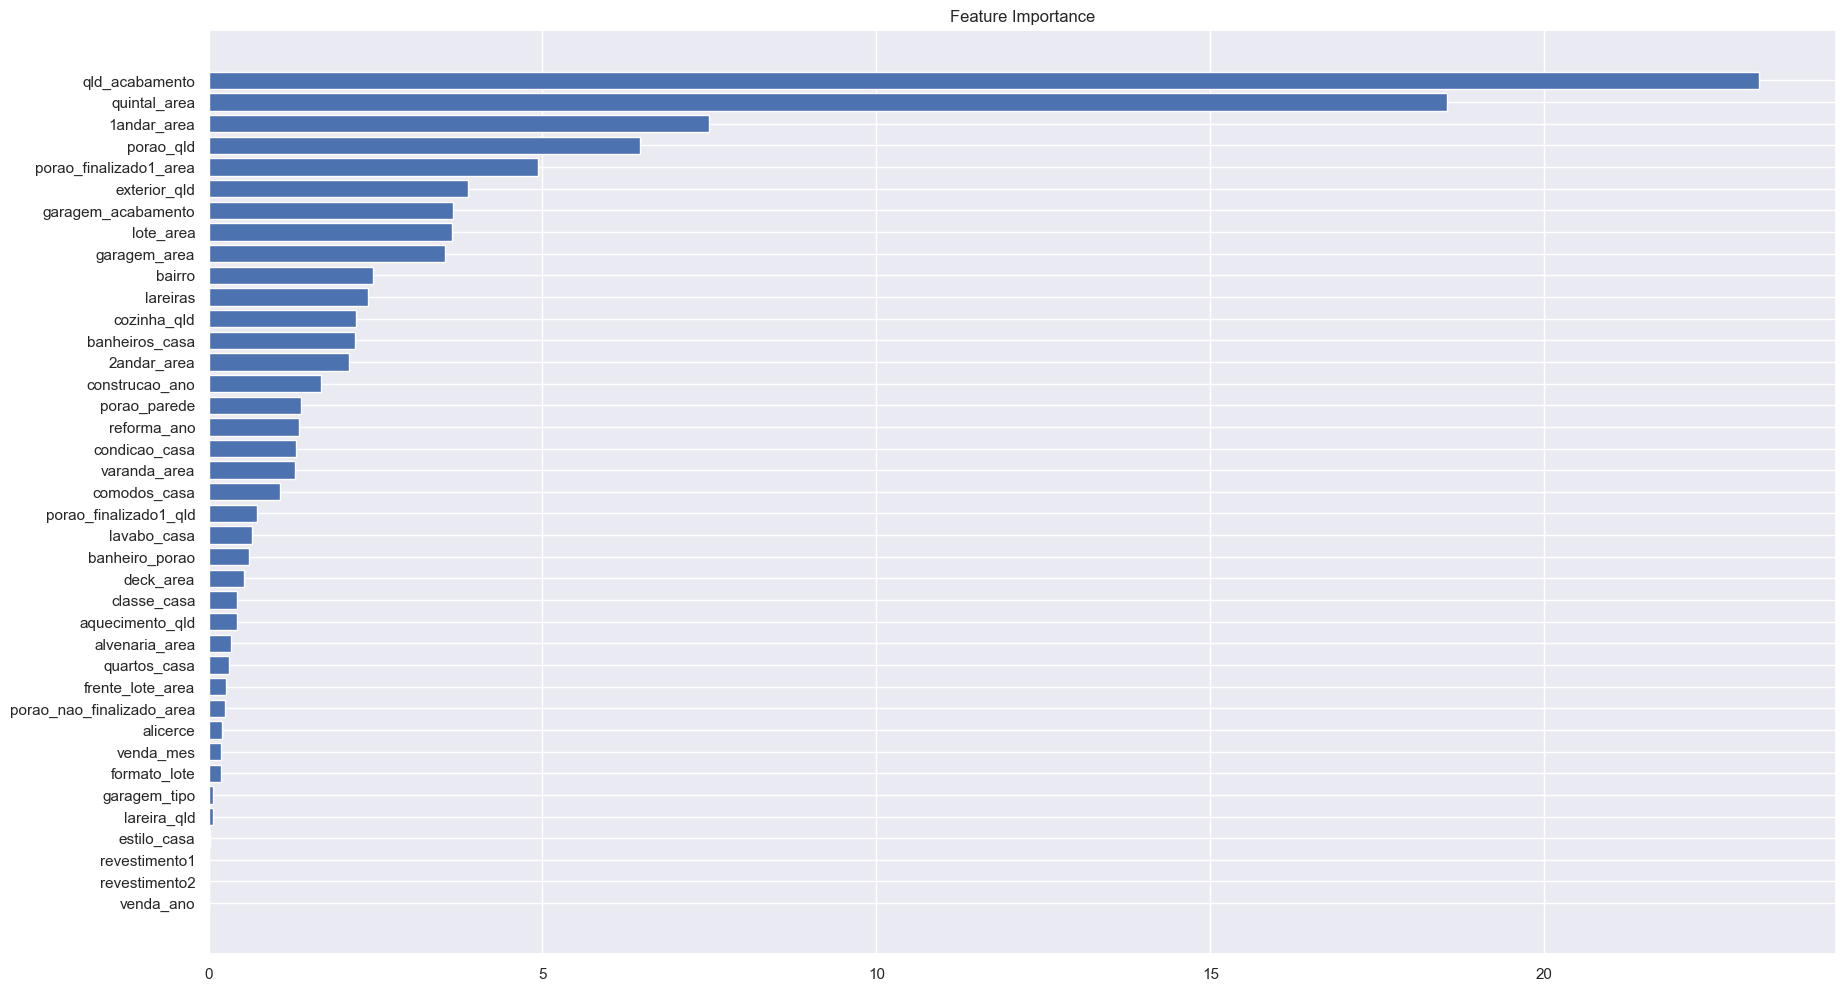

In [148]:
# Identifica as características categóricas no DataFrame de treinamento (todas as não numéricas)
categorical_features = list(X_train.select_dtypes(exclude=['int', 'float']).columns)

# Cria objetos de Pool para treinamento e teste, incluindo as características categóricas
train_pool = Pool(X_train, y_train, categorical_features)
test_pool = Pool(X_test, y_test, categorical_features)

# Configura o modelo CatBoostRegressor
model = CatBoostRegressor(iterations=500, max_depth=5, learning_rate=0.05, random_seed=42, logging_level='Silent')

# Treina o modelo CatBoostRegressor com os dados de treinamento
model.fit(X_train, y_train, eval_set=test_pool, cat_features=categorical_features, use_best_model=True, early_stopping_rounds=10)

# Calcula a importância das características usando o modelo treinado
feature_importance = model.feature_importances_

# Ordena os índices das características com base em sua importância
sorted_idx = np.argsort(feature_importance)

# Cria um gráfico de barras horizontais para visualizar a importância das características
fig = plt.figure(figsize=(21, 12))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance');

In [149]:
# Pega as 20 melhores features
melhores = list(np.array(X_test.columns)[sorted_idx][-20:])
melhores.remove('bairro')
print(X_train.shape)
df2[melhores].dtypes

(1168, 39)


comodos_casa               int64
varanda_area               int64
condicao_casa              int64
reforma_ano                int64
porao_parede              object
construcao_ano             int64
2andar_area                int64
banheiros_casa             int64
cozinha_qld               object
lareiras                   int64
garagem_area               int64
lote_area                  int64
garagem_acabamento        object
exterior_qld              object
porao_finalizado1_area     int64
porao_qld                 object
1andar_area                int64
quintal_area               int64
qld_acabamento             int64
dtype: object

In [150]:
X_train = X_train[melhores].copy()
X_test = X_test[melhores].copy()

## 4.3. Transformação dos dados

In [151]:
encoder = OrdinalEncoder()
cat = list(X_train.select_dtypes(exclude=[np.number]).columns)

# Transformando variáveis categóricas (dados de treino)
X_train[cat] = encoder.fit_transform(X_train[cat])

# Transformando variáveis categóricas (dados de teste)
X_test[cat] = encoder.fit_transform(X_test[cat])

## 4.4. Normalização dos dados

In [152]:
scaler = MinMaxScaler()

# Normalização dos dados de treino
X_train = scaler.fit_transform(X_train)

# Aplicar a mesma normalização aos dados de teste
X_test = scaler.transform(X_test)

In [153]:
# # SelectKBest
# quanti = X_train.select_dtypes(include=['int', 'float'])
# quali = X_train.select_dtypes(exclude=['int', 'float'])

# for col in quanti.isna():
#     quanti[col].fillna(quanti[col].median(), inplace=True)

# for col in quali.isna():
#     quali[col].fillna(quali[col].value_counts().index[0], inplace=True)

# print(quanti.shape)
# print(quali.shape)


# # ==============================================================================


# # Instanciando o modelo
# skb_numericos = SelectKBest(score_func=f_regression, k=15)

# # Definindo as variáveis X
# X_quanti = quanti.drop(columns=['venda_preco'])

# # Definindo a variável target
# y = df2.venda_preco

# # Treinando o modelo de seleção
# skb_numericos.fit(X_quanti, y)

# # Selecionando as k melhores features
# melhores_quanti = skb_numericos.get_feature_names_out()

# # ==============================================================================

# quali = pd.get_dummies(quali, drop_first=True)

# # Instanciando o modelo
# skb_categoricos = SelectKBest(score_func=chi2, k=15)

# # Definindo as variáveis X
# X_quali = quali.copy()

# # Definindo a variável target
# y = df2.venda_preco

# # Treinando o modelo de seleção
# skb_categoricos.fit(X_quali, y)

# # Selecionando as k melhores features
# melhores_quali = skb_categoricos.get_feature_names_out()

# # ==============================================================================

# melhores_quali

# 5 - Modeling

## 5.1. Regressão linear

In [154]:
# Criando o modelo de Regressão Linear Lasso
regressao = Lasso(
    alpha=0.01, 
    max_iter=10000, 
    random_state=42)

# Treinando o modelo
regressao.fit(X_train, y_train)

# Fazendo previsões nos dados de teste com o modelo treinado
y_pred = regressao.predict(X_test)

# Medindo a performance do modelo
metricas_regressao = plota_metricas("Regressão Linear", y_test, y_pred)
metricas_regressao

,Modelo,R2,MAE,MAPE,RMSE
0,Regressão Linear,0.838,21466.881,0.129,35261.114


## 5.2. Random Forest Regressor

In [155]:
# Criando o modelo
rf = RandomForestRegressor(max_depth=5, random_state=42)

# Treinando o modelo
rf.fit(X_train, y_train)

# Fazendo previsões nos dados de teste com o modelo treinado
y_pred = rf.predict(X_test)

# Medindo a performance do modelo
metricas_rf = plota_metricas("Random Forest", y_test, y_pred)
metricas_rf

,Modelo,R2,MAE,MAPE,RMSE
0,Random Forest,0.863,21010.710,0.135,32415.261


## 5.3. XGBoost Regressor

In [156]:
# Criando o modelo 
xgb = XGBRegressor(max_depth=2, random_state=42)

# Treinando o modelo
xgb.fit(X_train, y_train)

# Fazendo previsões nos dados de teste com o modelo treinado
y_pred = xgb.predict(X_test)

# Medindo a performance do modelo
metricas_xgb = plota_metricas("XGBoost", y_test, y_pred)
metricas_xgb

,Modelo,R2,MAE,MAPE,RMSE
0,XGBoost,0.867,18580.793,0.110,31956.860


# 6 - Escolhendo melhor modelo

In [157]:
# Comparando os modelos
tabela_performance = (
    pd.concat([metricas_regressao, metricas_rf, metricas_xgb])
    .sort_values("R2", ascending=False)
    .reset_index(drop=True)
)
tabela_performance

,Modelo,R2,MAE,MAPE,RMSE
0,XGBoost,0.867,18580.793,0.110,31956.860
1,Random Forest,0.863,21010.710,0.135,32415.261
2,Regressão Linear,0.838,21466.881,0.129,35261.114


# 7 - Tunagem de hiperparâmetros

In [158]:
# # Configurando o nível de log do Optuna para suprimir saída detalhada
# optuna.logging.set_verbosity(optuna.logging.WARNING)

# # Definindo a função objetivo para otimização
# def objective(trial):

#     # Parâmetros e faixa de valores a serem testados
#     max_depth = trial.suggest_int("rf_max_depth", 2, 64)
#     min_samples_split = trial.suggest_int("rf_min_samples_split", 2, 10)
#     n_estimators = trial.suggest_int("n_estimators", 2, 50)
   
#     # Cria um modelo com os hiperparâmetros sugeridos
#     rf_model = RandomForestRegressor(
#         max_depth=max_depth,
#         min_samples_split=min_samples_split,
#         n_estimators=n_estimators,
#         random_state=42)
    
#     # Calcula a pontuação média usando validação cruzada
#     score = cross_val_score(rf_model, X_train, y_train, cv=3, scoring='neg_root_mean_squared_error').mean()   
#     return score

# # Cria uma instância de estudo do Optuna para maximização
# study = optuna.create_study(direction="maximize")

# # Realiza a otimização da função objetivo com 100 iterações de teste
# study.optimize(objective, n_trials=50)

# # Obtém a melhor tentativa após a otimização
# trial = study.best_trial

# # Imprime a melhor pontuação encontrada
# print("Best Score: ", trial.value)

# # Imprime os hiperparâmetros correspondentes à melhor pontuação
# print("Best Params: ")
# for key, value in trial.params.items():
#     print("  {}: {}".format(key, value))


# 8 - Modelo final

In [159]:
# Instanciando o melhor modelo com os melhores parâmetros
rf = RandomForestRegressor(
    max_depth=57, 
    min_samples_split=6, 
    n_estimators=48, 
    random_state=42
)

# Treinando o modelo
rf.fit(X_train, y_train)

# Fazendo previsões nos dados de teste com o modelo treinado
y_pred = rf.predict(X_test)

# Verificando a performance finalo do modelo
metricas_rf = plota_metricas("Random Forest", y_test, y_pred)
metricas_rf

,Modelo,R2,MAE,MAPE,RMSE
0,Random Forest,0.890,18423.648,0.112,29094.053


# 9 - Submissão Kaggle

In [160]:
# Leitura dos dados
df_validation = df_validation_raw.copy()
df_validation.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.000,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,NaN,0.000,TA,TA,CBlock,TA,TA,No,Rec,468.000,LwQ,144.000,270.000,882.000,GasA,TA,Y,SBrkr,896,0,0,896,0.000,0.000,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.000,Unf,1.000,730.000,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.000,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.000,TA,TA,CBlock,TA,TA,No,ALQ,923.000,Unf,0.000,406.000,1329.000,GasA,TA,Y,SBrkr,1329,0,0,1329,0.000,0.000,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.000,Unf,1.000,312.000,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal


In [161]:
# Renomeando as colunas
df_validation.columns = [
        'id', 'classe_casa', 'zoneamento', 'frente_lote_area', 'lote_area', 'pavimento_rua',
        'pavimento_beco', 'formato_lote', 'planicidade', 'conveniencias_proximas', 'tipo_lote',
        'inclinacao', 'bairro', 'proximidade1', 'proximidade2', 'tipo_casa',
        'estilo_casa', 'qld_acabamento', 'condicao_casa', 'construcao_ano', 'reforma_ano',
        'estilo_telhado', 'material_telhado', 'revestimento1', 'revestimento2', 'tp_alvenaria',
        'alvenaria_area', 'exterior_qld', 'exterior_cond', 'alicerce', 'porao_qld',
        'porao_cond', 'porao_parede', 'porao_finalizado1_qld', 'porao_finalizado1_area',
        'porao_finalizado2_qld', 'porao_finalizado2_area', 'porao_nao_finalizado_area', 'porao_total_area', 'aquecimento_tp',
        'aquecimento_qld', 'ar_condic', 'painel_eletrico', '1andar_area', '2andar_area',
        'area_baixa_qld', 'quintal_area', 'banheiro_porao', 'lavabo_porao', 'banheiros_casa',
        'lavabo_casa', 'quartos_casa', 'cozinhas', 'cozinha_qld',
        'comodos_casa', 'deducoes_qld', 'lareiras', 'lareira_qld', 'garagem_tipo',
        'garagem_ano', 'garagem_acabamento', 'garagem_qtd_carros', 'garagem_area', 'garagem_qld',
        'garagem_cond', 'calcada', 'deck_area', 'varanda_area',
        'varanda_fechada_area', 'varanda_3_lados_area', 'varanda_telada_area', 'piscina_area', 'piscina_qld',
        'cerca_qld', 'area_plus', 'valor_area_plus', 'venda_mes', 'venda_ano', 'venda_tipo',
        'venda_cond', 
]

In [162]:
# =====================================================
# Excluindo features
# =====================================================
# Excluindo as features com baixa variância
df_validation.drop(columns=features_constantes, inplace=True)

# Excluindo as features altamente correlacionadas
df_validation.drop(columns=['garagem_ano', 'garagem_qtd_carros', 'porao_total_area'], inplace=True)

# =====================================================
# Preenchendo faltantes nos dados
# =====================================================
num = df_validation.select_dtypes(include=np.number)
cat = df_validation.select_dtypes(exclude=np.number)

# Colunas numéricas (mediana)
for col in num.columns:
    df_validation[col].fillna(df_validation[col].median(), inplace=True)

# Colunas categóricas (moda)
for col in cat.columns:
    df_validation[col].fillna(df_validation[col].value_counts().index[0], inplace=True)

# =====================================================
# Selecionando as melhores features
# =====================================================
melhores.append('id')
df_validation = df_validation[melhores].copy()

# Modificando a ordem das colunas
df_validation = df_validation[['id', 'comodos_casa', 'varanda_area', 'condicao_casa', 'reforma_ano',
       'porao_parede', 'construcao_ano', '2andar_area', 'banheiros_casa',
       'cozinha_qld', 'lareiras', 'garagem_area', 'lote_area',
       'garagem_acabamento', 'exterior_qld', 'porao_finalizado1_area',
       'porao_qld', '1andar_area', 'quintal_area', 'qld_acabamento']]


df_validation_final = df_validation.drop(columns=['id'])

# =======================================================
# Transformação
# =======================================================
cat = list(df_validation_final.select_dtypes(exclude=[np.number]).columns)

# Transformando variáveis categóricas
df_validation_final[cat] = encoder.fit_transform(df_validation_final[cat])

# Normalização dos dados de treino
df_validation_final = scaler.fit_transform(df_validation_final)

In [163]:
df_validation.head()

,id,comodos_casa,varanda_area,condicao_casa,reforma_ano,porao_parede,construcao_ano,2andar_area,banheiros_casa,cozinha_qld,lareiras,garagem_area,lote_area,garagem_acabamento,exterior_qld,porao_finalizado1_area,porao_qld,1andar_area,quintal_area,qld_acabamento
0,1461,5,0,6,1961,No,1961,0,1,TA,0,730.000,11622,Unf,TA,468.000,TA,896,896,5
1,1462,6,36,6,1958,No,1958,0,1,Gd,0,312.000,14267,Unf,TA,923.000,TA,1329,1329,6
2,1463,6,34,5,1998,No,1997,701,2,TA,1,482.000,13830,Fin,TA,791.000,Gd,928,1629,5
3,1464,7,36,6,1998,No,1998,678,2,Gd,1,470.000,9978,Fin,TA,602.000,TA,926,1604,6
4,1465,5,82,5,1992,No,1992,0,2,Gd,0,506.000,5005,RFn,Gd,263.000,Gd,1280,1280,8


In [164]:
# Fazer a predição
df_validation['y_predito'] = rf.predict(df_validation_final)

# Excluindo as colunas desnecessárias
df_submissao = df_validation[['id', 'y_predito']].copy()

# Renomeando as colunas
df_submissao.columns = ['Id', 'SalePrice']

df_submissao.to_csv('../data/house_prices/submissao2.csv', index=False)

## Mean Absolute Error

O MAE é calculado usando o módulo da subtração entre o valor do que realmente aconteceu e o valor previsto, dividido pelo número n de amostras. 


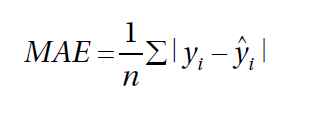

-----------------------------------

## Mean Squared Error (MSE)  

MSE é a média da somatória do erro ao quadrado. Elevar o erro ao quadrado evita que os erros fiquem negativos e, portanto, se subtraiam na somatória.

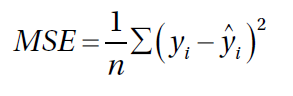

--------------------------

## Root Mean Squared Error

A vantagem de utilizar o RMSE é que, ao computar a raiz quadrada, o erro passa a ter a mesma escala do indicador. Um RMSE baixo, significa que a performance do modelo foi boa, pois o erro se aproxima de zero.

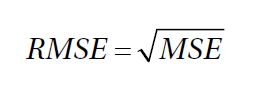

--------------------------

## Mean Absolute Percentage Error

Conhecido como MAPE, é a porcentagem relativa ao valor observado. O cálculo é feito obtendo a somatória da diferença entre o valor que realmente ocorreu com o valor previsto (resultado do erro), dividido pelo valor observado. 

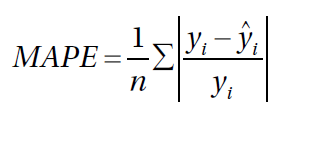

--------------------------


## R2 Score

É uma medida de performance e não uma medida de erro. O valor do R2 fica entre 0 e 1, sendo 1 perfeito e 0 ruim. Para convertermos em porcentagem, basta multiplicarmos o resultado por 100%.

O valor de R2 só será negativo se a previsão for mais que 100% errada.

Intuitivamente, o modelo mais “simples” que podemos pensar para fazer uma previsão, é pegarmos a média da variável estudada e utilizá-la como uma estimativa.

O valor de R2 indica em qual porcentagem o seu modelo de previsão será melhor em relação ao uso da média como estimativa. 

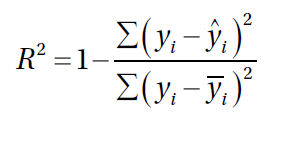